## Uninstall matplotlib higher version

In [1]:
pip uninstall -y matplotlib

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2
Note: you may need to restart the kernel to use updated packages.


## Install matplotlib==3.2.2

In [2]:
pip install matplotlib==3.2.2

  Using cached matplotlib-3.2.2-cp37-cp37m-macosx_10_9_x86_64.whl (12.5 MB)
Note: you may need to restart the kernel to use updated packages.


## Install libraries for backtesting

In [3]:
pip install tabulate backtrader requests

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [4]:
from datetime import datetime
import backtrader as bt
import locale
from util import *
from krx_wr_script import *
from tabulate import tabulate
from tqdm import tqdm
locale.setlocale(locale.LC_ALL, 'ko_KR')

'ko_KR'

## This is EMA-Crossover Strategy with RSI
Set your strategy (e.g. p_short, p_middle ...)

In [5]:
class EmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        p_short=5,  # period for the fast moving average
        p_middle=20,  # period for the slow moving average
        p_long=100,
    )

    def __init__(self):
        ema1 = bt.ind.EMA(period=self.p.p_short)  # fast moving average
        ema2 = bt.ind.EMA(period=self.p.p_middle)  # slow moving average
        self.crossover = bt.ind.CrossOver(ema1, ema2)  # crossover signal
        self.rsi_14 = bt.ind.RSI_EMA(period=14)
        self.holding = 0


    def next(self):
        current_stock_price = self.data.close[0]

        if not self.position:  # not in the market
            if self.crossover < 0:  # if fast crosses slow to the upside
                available_stocks = self.broker.getcash() / current_stock_price
                self.buy(size=int((available_stocks) * 0.3))
            if self.rsi_14 < 20:
                # print(self.broker.getcash())
                available_stocks = self.broker.getcash() / current_stock_price
                self.buy(size=int((available_stocks) * 0.7))
        elif self.position:
            if self.crossover < 0:
                available_stocks = self.broker.getcash() / current_stock_price
                self.buy(size=int((available_stocks) * 0.2))
            if self.rsi_14 < 30:
                available_stocks = self.broker.getcash() / current_stock_price
                self.buy(size=int((available_stocks) * 0.15))
        # if self.rsi_14 < 10:
        #     # print(self.broker.getcash())
        #     available_stocks = self.broker.getcash() / current_stock_price
        #     self.buy(size=int((available_stocks) * 0.5))

        elif self.crossover > 0:  # in the market & cross to the downside
            available_stocks = self.broker.getcash() / current_stock_price
            if int((self.holding) * 0.15) > 0:
                self.sell(size=int((self.holding) * 0.5))
            else:
                self.close()
            # self.close()  # close long position
        if self.rsi_14 >= 70:
            available_stocks = self.broker.getcash() / current_stock_price
            if int((self.holding) * 0.15) > 0:
                self.sell(size=int((self.holding) * 0.25))
            else:
                self.close()

    def notify_order(self, order):
        if order.status not in [order.Completed]:
            return

        if order.isbuy():
            action = 'Buy'
        elif order.issell():
            action = 'Sell'

        stock_price = self.data.close[0]
        cash = self.broker.getcash()
        value = self.broker.getvalue()
        self.holding += order.size

        print('%s[%d] holding[%d] price[%d] cash[%.2f] value[%.2f]'
              % (action, abs(order.size), self.holding, stock_price, cash, value))

## Setting stock

In [ ]:
util_bt = util()
stats = []
stock_name = '코리아센터'

## Loading krx csv -> Setting for cerebro

In [ ]:
stock_csv = pykrx_read_csv(stock_name, util_bt.Krx_Char_folder_path)
stock_csv['date'] = pd.to_datetime(stock_csv['date'])
stock_csv.set_index(stock_csv['date'], inplace=True)
del(stock_csv['date'])
stock_csv['volume'] = stock_csv['volume'].replace(to_replace=0, value=1)

Buy[598] holding[598] price[5161] cash[6998028.04] value[10084306.04]
Buy[228] holding[826] price[4457] cash[5972260.60] value[9653742.60]
Buy[200] holding[1026] price[3971] cash[5075671.00] value[9149917.00]
Buy[191] holding[1217] price[3754] cash[4331769.17] value[8900387.17]
Buy[173] holding[1390] price[3345] cash[3747939.84] value[8397489.84]
Buy[168] holding[1558] price[3217] cash[3169705.68] value[8181791.68]
Buy[147] holding[1705] price[3184] cash[2724583.21] value[8153303.21]
Buy[128] holding[1833] price[2922] cash[2315061.80] value[7671087.80]
Buy[118] holding[1951] price[2225] cash[1966856.78] value[6307831.78]
Buy[132] holding[2083] price[2423] cash[1671246.74] value[6718355.74]
Buy[103] holding[2186] price[2403] cash[1429538.29] value[6682496.29]
Buy[89] holding[2275] price[2527] cash[1211408.90] value[6960333.90]
Buy[71] holding[2346] price[2668] cash[1026653.13] value[7285781.13]
Buy[57] holding[2403] price[2725] cash[872959.35] value[7421134.35]
Sell[600] holding[1803] p

<IPython.core.display.Javascript object>


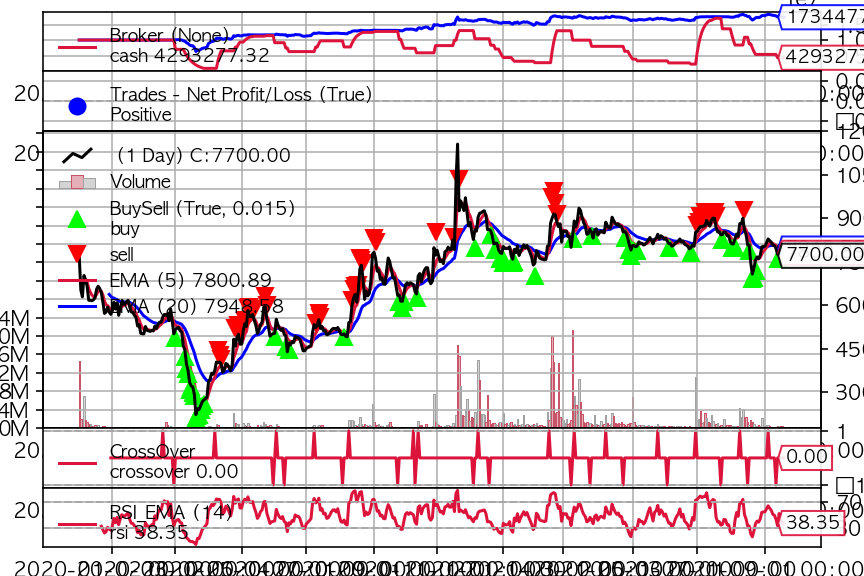

[[<Figure size 432x288 with 6 Axes>]]

In [6]:
cerebro = bt.Cerebro()  # create a "Cerebro" engine instance
cerebro.broker.setcash(10000000)
cerebro.broker.setcommission(0.002)

# Create a data feed
data = bt.feeds.PandasData(dataname=stock_csv)

cerebro.adddata(data)  # Add the data feed

cerebro.addstrategy(EmaCross)  # Add the trading strategy

start_value = cerebro.broker.getvalue()
cerebro.run()  # run it all
final_value = cerebro.broker.getvalue()

print('* start value : %s won' % locale.format_string('%d', start_value, grouping=True))
print('* final value : %s won' % locale.format_string('%d', final_value, grouping=True))
print('* earning rate : %.2f %%' % ((final_value - start_value)/ start_value * 100.0))

earning_rate = round(((final_value - start_value)/ start_value * 100.0),2)
buy_hold = (((stock_csv.iloc[len(stock_csv)-1].close - stock_csv.iloc[0].close) / stock_csv.iloc[0].close) * 100)
final_value = locale.format_string('%d', final_value, grouping=True)

cerebro.plot()  # and plot it with a single command